<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Case Study - Situation

A Polish client is providing insurance services in the context of bankrupt companies. The client would like you to predict the likelihood of companies to go bankrupt based on financial characteristics. To help you with your task, you should use historical data on company survival provided.

## Importing the necessary the libraries

In [1]:
%%time
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
from scipy.io import arff

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from numpy import where
from numpy import sort
import math

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import plot_importance

import pickle

Wall time: 3.32 s


## Loading the data

As the data is collected over the span of 5 years, we see five different datasets. Each dataset has 64 features and a binary classification outcome which says whether the company bankrupted or not.
1 indicating that the company did not bankrupt and 0 indicating that the company bankrupted.

The purpose of this study is to create a predictive model which predicts the likelihood of companies to go bankrupt based on financial characteristics. Plus, the required task is to predict the chance of bankruptcy after 1, 2 and 3 years from the features in the data set.

We need to develop a predictive model which is trained on general financial features related to the company, and as we have data over the span of several years, we can combine the data from the 1st, 2nd and 3rd year. Let a classification model familiarized with the features and then test this model on the untouched & unseen data from the 4th and 5th year.

In [2]:
%%time
# Loading Data
data1 = arff.loadarff('data/1year.arff')
df1 = pd.DataFrame(data1[0])

data2 = arff.loadarff('data/2year.arff')
df2 = pd.DataFrame(data2[0])

data3 = arff.loadarff('data/3year.arff')
df3 = pd.DataFrame(data3[0])

data4 = arff.loadarff('data/4year.arff')
df4 = pd.DataFrame(data4[0])

data5 = arff.loadarff('data/5year.arff')
df5 = pd.DataFrame(data5[0])

# Cocatenating data of 1, 2 & 3 year in one dataframe
frames_train = [df1, df2, df3]
df123 = pd.concat(frames_train)
# Cocatenating data of 4 & 5 year in one dataframe
frames_test = [df4, df5]
df45 = pd.concat(frames_test)

# Putting both these datasets into a list
df_list = [df123, df45]

Wall time: 3.45 s


In [3]:
df_list[0]

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.388250,0.249760,1.330500,1.13890,0.504940,...,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.000000,0.258340,0.996010,1.69960,0.497880,...,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.000000,0.309060,0.436950,1.30900,0.304080,...,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.149880,0.092704,1.866100,1.05710,0.573530,...,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.187320,0.187320,0.630700,1.15590,0.386770,...,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10498,0.002861,0.58067,-0.223860,0.51658,-31.8660,0.002861,0.002861,0.618550,1.01200,0.359170,...,0.011834,0.007966,0.98817,0.327360,38.1420,39.1500,42.202,8.6489,5.2646,b'1'
10499,-0.051968,0.55254,0.147150,2.16980,12.7480,-0.051968,-0.034361,0.669830,0.94694,0.370110,...,-0.056037,-0.140410,1.05600,1.153000,14.4930,9.2851,32.761,11.1410,1.9276,b'1'
10500,-0.135900,0.83954,-0.342010,0.46526,-145.3100,-0.219120,-0.131860,0.191130,1.09990,0.160460,...,0.144120,-0.846930,0.85427,0.814200,6.2737,9.6966,212.230,1.7198,1.5659,b'1'
10501,0.009423,0.50028,0.261630,1.52300,-10.1580,0.009423,0.007700,0.989900,1.01230,0.495230,...,0.012186,0.019027,0.98781,0.000000,5.9675,4.3536,98.240,3.7154,7.8068,b'1'


In [4]:
df_list[1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15702 entries, 0 to 5909
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   15698 non-null  float64
 1   Attr2   15698 non-null  float64
 2   Attr3   15698 non-null  float64
 3   Attr4   15638 non-null  float64
 4   Attr5   15670 non-null  float64
 5   Attr6   15698 non-null  float64
 6   Attr7   15698 non-null  float64
 7   Attr8   15665 non-null  float64
 8   Attr9   15701 non-null  float64
 9   Attr10  15698 non-null  float64
 10  Attr11  15698 non-null  float64
 11  Attr12  15638 non-null  float64
 12  Attr13  15681 non-null  float64
 13  Attr14  15698 non-null  float64
 14  Attr15  15688 non-null  float64
 15  Attr16  15665 non-null  float64
 16  Attr17  15665 non-null  float64
 17  Attr18  15698 non-null  float64
 18  Attr19  15681 non-null  float64
 19  Attr20  15681 non-null  float64
 20  Attr21  15441 non-null  float64
 21  Attr22  15698 non-null  float64
 22 

## Pre-processing the datasets

All the feature / attribute columns are already in the float datatype
But, the class column does not exactly indicate in binary.

In [5]:
df123['class'].value_counts()

b'0'    26537
b'1'     1166
Name: class, dtype: int64

Therefore, using a simple LabelEncoder function, we convert b'0' to 0 and b'1' to 1

In [6]:
# Label Encoding class column -> 0, 1
for i in df_list:
    i['class'] = LabelEncoder().fit_transform(i['class'])

In [7]:
df123['class'].value_counts()

0    26537
1     1166
Name: class, dtype: int64

### Missing values

One very alarming problem with the dataset is that has a lot of missing values spread through many columns and almost half of the rows

In [8]:
# Count of null values per column
missing_list = df123.isnull().sum().tolist()
print("Missing values per feature")
for i in range(len(missing_list)):
    print("Attr{0}: {1}".format(str(i+1), missing_list[i]))

Missing values per feature
Attr1: 4
Attr2: 4
Attr3: 4
Attr4: 70
Attr5: 57
Attr6: 4
Attr7: 4
Attr8: 57
Attr9: 8
Attr10: 4
Attr11: 40
Attr12: 70
Attr13: 106
Attr14: 4
Attr15: 22
Attr16: 58
Attr17: 57
Attr18: 4
Attr19: 107
Attr20: 106
Attr21: 5593
Attr22: 4
Attr23: 106
Attr24: 576
Attr25: 4
Attr26: 58
Attr27: 1732
Attr28: 474
Attr29: 4
Attr30: 106
Attr31: 106
Attr32: 226
Attr33: 70
Attr34: 57
Attr35: 4
Attr36: 4
Attr37: 11994
Attr38: 4
Attr39: 106
Attr40: 70
Attr41: 483
Attr42: 106
Attr43: 106
Attr44: 106
Attr45: 1266
Attr46: 71
Attr47: 189
Attr48: 5
Attr49: 106
Attr50: 57
Attr51: 4
Attr52: 189
Attr53: 474
Attr54: 474
Attr55: 1
Attr56: 106
Attr57: 3
Attr58: 68
Attr59: 3
Attr60: 1270
Attr61: 55
Attr62: 106
Attr63: 70
Attr64: 474
Attr65: 0


In [9]:
df123['Attr37'].isnull().sum()

11994

In [10]:
df45['Attr37'].isnull().sum()

6990

<AxesSubplot:>

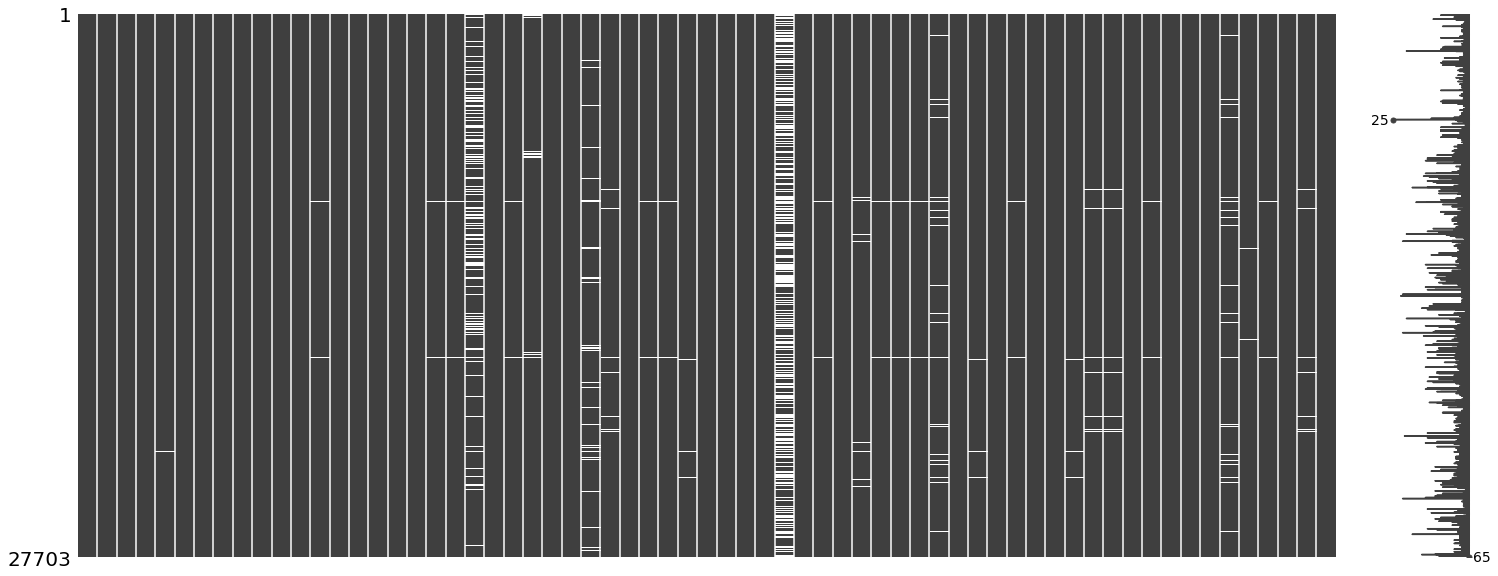

In [11]:
msno.matrix(df123)

<AxesSubplot:>

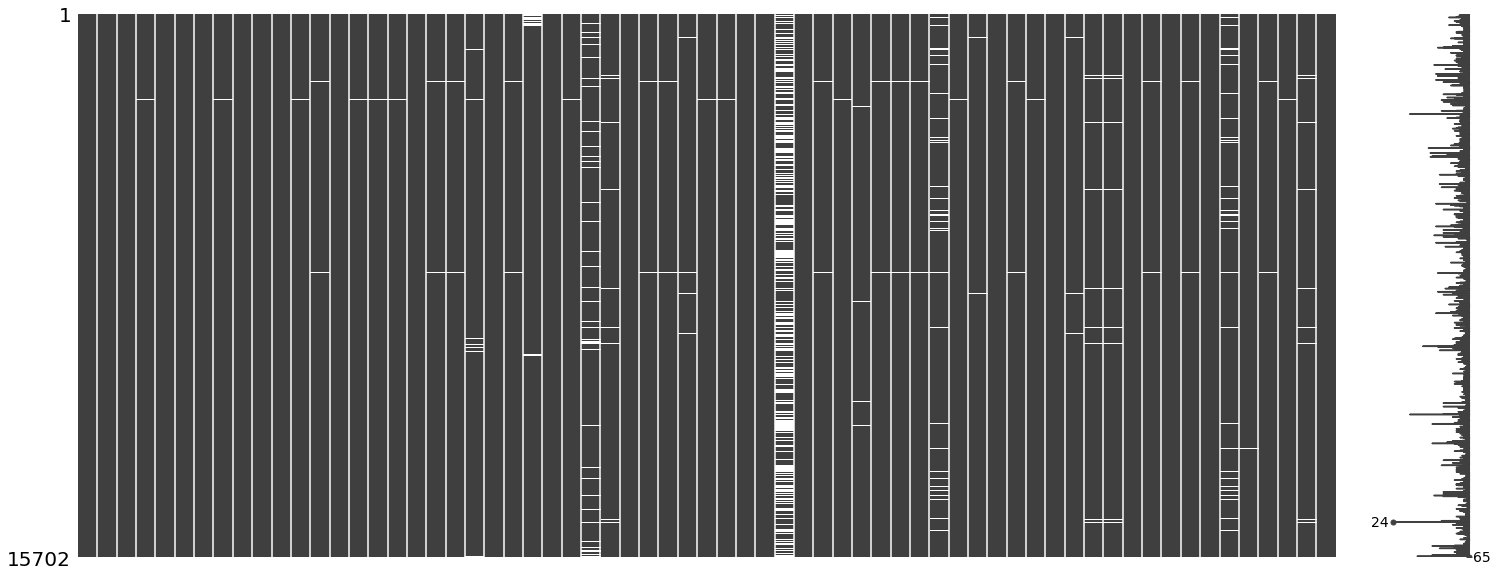

In [12]:
msno.matrix(df45)

From both the datasets, Attr37 ((current assets - inventories) / long-term liabilities) has a lot of missing values.

In df123 for attribute 37, from 27703 entries 11994 were missing.
In df45 for attribute 37, from 15702 entries 6990 were missing.
It is almost half of the total entries.

I was planning to drop this feature altogther, but after analysis (show later in the study), this attribute even with mean filled values, is the 7th best feature affecting the model's performance, and the exlusion of which, slightly degrades the model's performance. Especially, this feature apparently helped give less false-negative cases (where the company is actually bankrupted but the model predicts that it's not). It was a matter of model (with attr37) giving 299 FN cases and model without attr37 giving 333 FN cases.

I have shown the model accuracy with and without the Attr37 (and also one without Attr21 which has 5593 missing values but actually becomes the best feature for the model).

Coming to the rest of the missing values, I use the SimpleImuter function to fill the missing values of a column by the mean of that column.

In [13]:
# Filling missing values in all the datasets with mean
imputer=SimpleImputer(missing_values=np.nan,strategy='mean')
for i in df_list:
    imputer = imputer.fit(i.loc[:, i.columns != 'class'])
    i.loc[:, i.columns != 'class'] = imputer.transform(i.loc[:, i.columns != 'class'])

<IPython.core.display.Javascript object>

### Imbalanced Dataset

Imbalanced Dataset - Now, we see that the data is severly imbalanced. As expected, only a few companies would go bankrupt compared to the companies which wouldn't.
But, in Machine Learning, an imbalanced dataset gives a false pretense of high accuracy. 
Because, if majoirty of the companies survived, 
a model can easily predict that scenario to be true and be accurate all of the time.
In this case, the majority class holds 95% of the total classes.

Since, we need to equally give importance to each class - into predicting bankruptcy or solvency. 
We would need to handle this problem as well.

Now, there are several strategies to tackle the problem of an Imbalanced Dataset. From my study and experience so far, I have mostly come accross:
1. Resampling
2. Class penalty - Cost-sensitive Logistic Regression. Cost-sensitive Decision Trees. Cost-sensitive Support Vector Machines.

This is an example of an Anomaly / Fraud Detection problems. In principle, minority classes can be considered outliars by unsupervised ml algrotihms. Anomaly / Fraud Detection problems often have an Imbalanced Datasets.

From my previous studies and analysis, Oversampling has turned out to be a very good factor in resampling the dataset.
Oversampling using SMOTE (SMOTE: Synthetic Minority Over-sampling Technique) creates a new, synthetic data point to adjust the class distribution of a data set (i.e. the ratio between the different classes/categories represented)..

In [14]:
df123['class'].value_counts(normalize=True) * 100

0    95.79107
1     4.20893
Name: class, dtype: float64

In [15]:
df45['class'].value_counts(normalize=True) * 100

0    94.109031
1     5.890969
Name: class, dtype: float64

In [16]:
def plot_class_dist(df):
    ax = df['class'].value_counts().plot(kind='barh', figsize=(8,5),
                                            color=['r', 'g'], fontsize=12);
    ax.set_alpha(0.8)
    ax.set_title("Imbalanced Dataset -> Class Distribution", fontsize=12)
    ax.set_xlabel("Class", fontsize=12)

    totals = []

    for i in ax.patches:
        totals.append(i.get_width())

    total = sum(totals)

    for i in ax.patches:
        ax.text(i.get_width()+.3, i.get_y()+.28, \
                str(round((i.get_width()/total)*100, 2))+'%', fontsize=12,
    color='Black')

    ax.invert_yaxis()

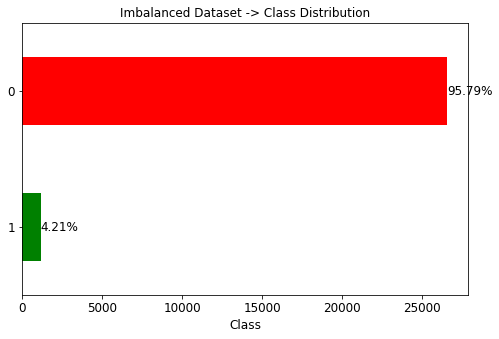

In [17]:
plot_class_dist(df_list[0])

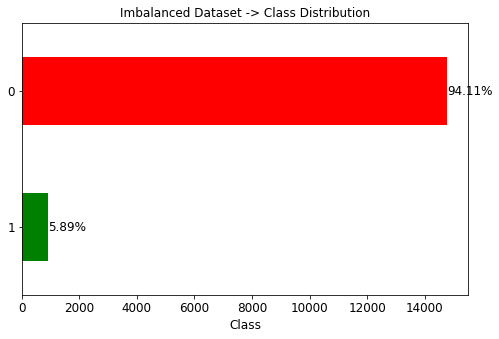

In [18]:
plot_class_dist(df_list[1])

In [19]:
# Scatter plot of data before and after oversampling
def plot_imbalancing(df):
    data = df.values
    X = data[:, :-1]
    y = data[:, -1]
    
    counter = Counter(y)
    print(counter)

    for label, _ in counter.items():
        row_ix = where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    plt.legend()
    plt.show()
    
    oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
    X, y = oversample.fit_resample(X, y)
    
    counter = Counter(y)
    print(counter)

    for label, _ in counter.items():
        row_ix = where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    plt.legend()
    plt.show()

Counter({0.0: 26537, 1.0: 1166})


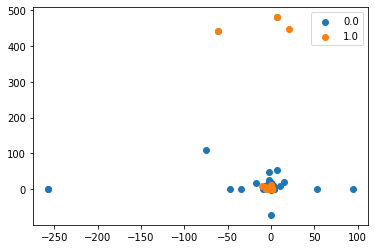

Counter({0.0: 26537, 1.0: 26537})


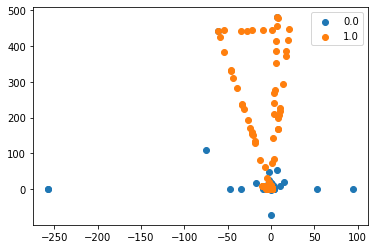

In [20]:
plot_imbalancing(df123)

Using the SMOTE technique, we oversample the dataset and create equal distribution of classes throughout the dataset.

## Comparing different Machine Learning models

In this analysis, I compare different ML models to basically see how a model performs on this dataset by comparing it's accuracy and inference time.

Notably, I evaluate here a Logistic Regression model, a Random Forest Classifier, a KNeighbors Classifier, a Support Vector Classifier, a Gaussian Naive Bayes model and a XGBoost Classifier

In [21]:
data123 = df123.values
X123 = data123[:, :-1]
y123 = data123[:, -1]

oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
X123, y123 = oversample.fit_resample(X123, y123)

X123_train, X123_test, Y123_train, Y123_test = train_test_split(X123, y123, test_size=0.3, random_state=0)

In [22]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier(verbose=False))
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['Survived', 'Bankrupted']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

In [23]:
%%time
final = run_exps(X123_train, Y123_train, X123_test, Y123_test)

LogReg
              precision    recall  f1-score   support

    Survived       0.56      0.78      0.66      7957
  Bankrupted       0.65      0.39      0.49      7966

    accuracy                           0.59     15923
   macro avg       0.60      0.59      0.57     15923
weighted avg       0.60      0.59      0.57     15923

RF
              precision    recall  f1-score   support

    Survived       0.99      0.98      0.98      7957
  Bankrupted       0.98      0.99      0.98      7966

    accuracy                           0.98     15923
   macro avg       0.98      0.98      0.98     15923
weighted avg       0.98      0.98      0.98     15923

KNN
              precision    recall  f1-score   support

    Survived       0.92      0.78      0.85      7957
  Bankrupted       0.81      0.93      0.87      7966

    accuracy                           0.86     15923
   macro avg       0.87      0.86      0.86     15923
weighted avg       0.87      0.86      0.86     15923

SVM
 

In [24]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## Performance Metrics
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## Time Metrics
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

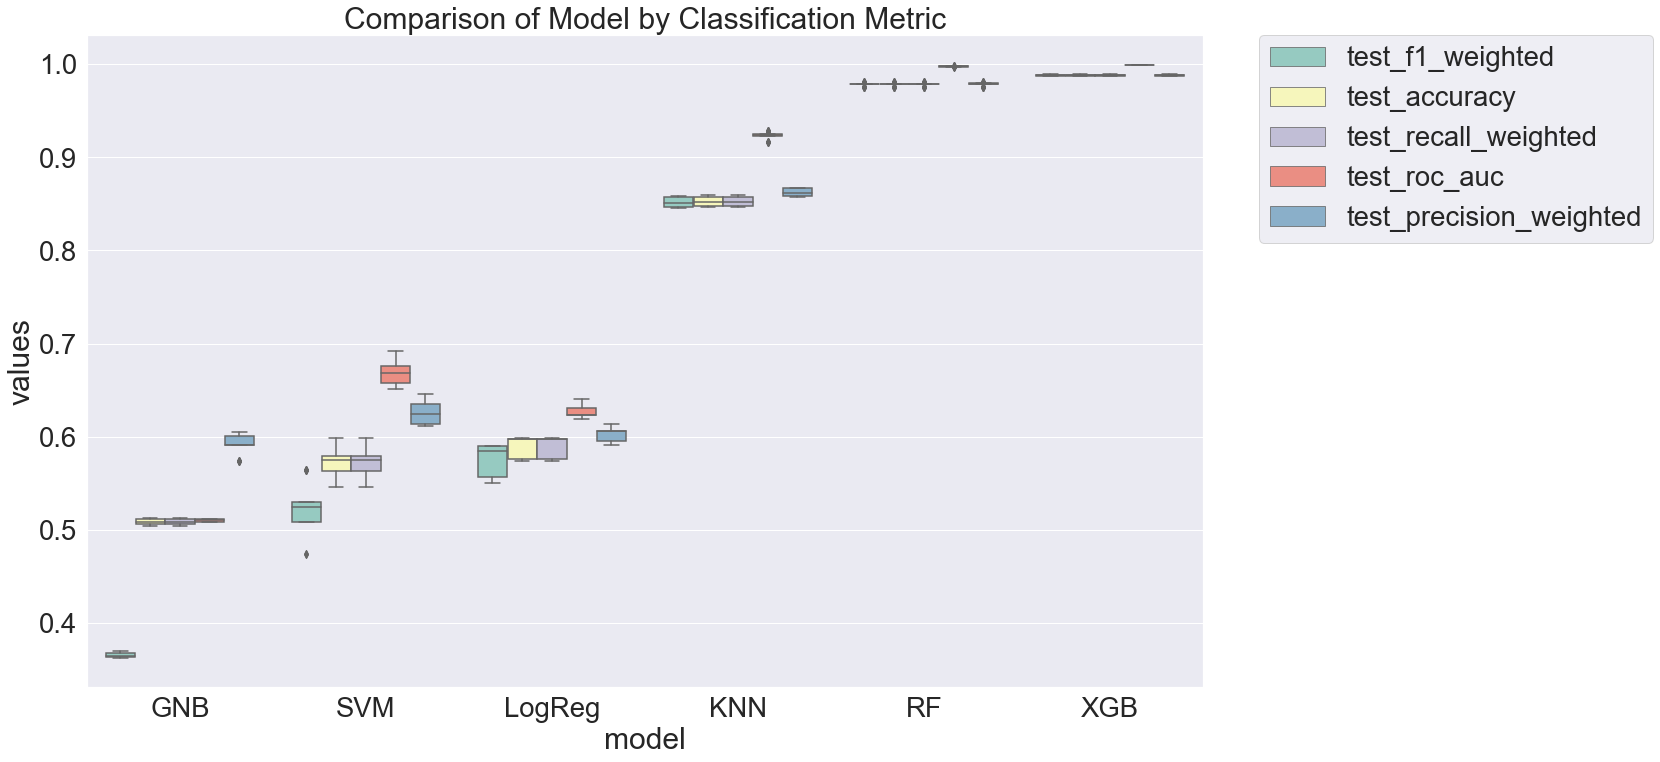

In [25]:
def plot_model_comparison():
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of Model by Classification Metric')
plot_model_comparison()

It is immediately clear that LRs, SVMs & NBs fit our data rather poorly across all metrics and that the ensemble decision tree models (Random Forest and XGBoost) fit the data very well, especially XGBoost.

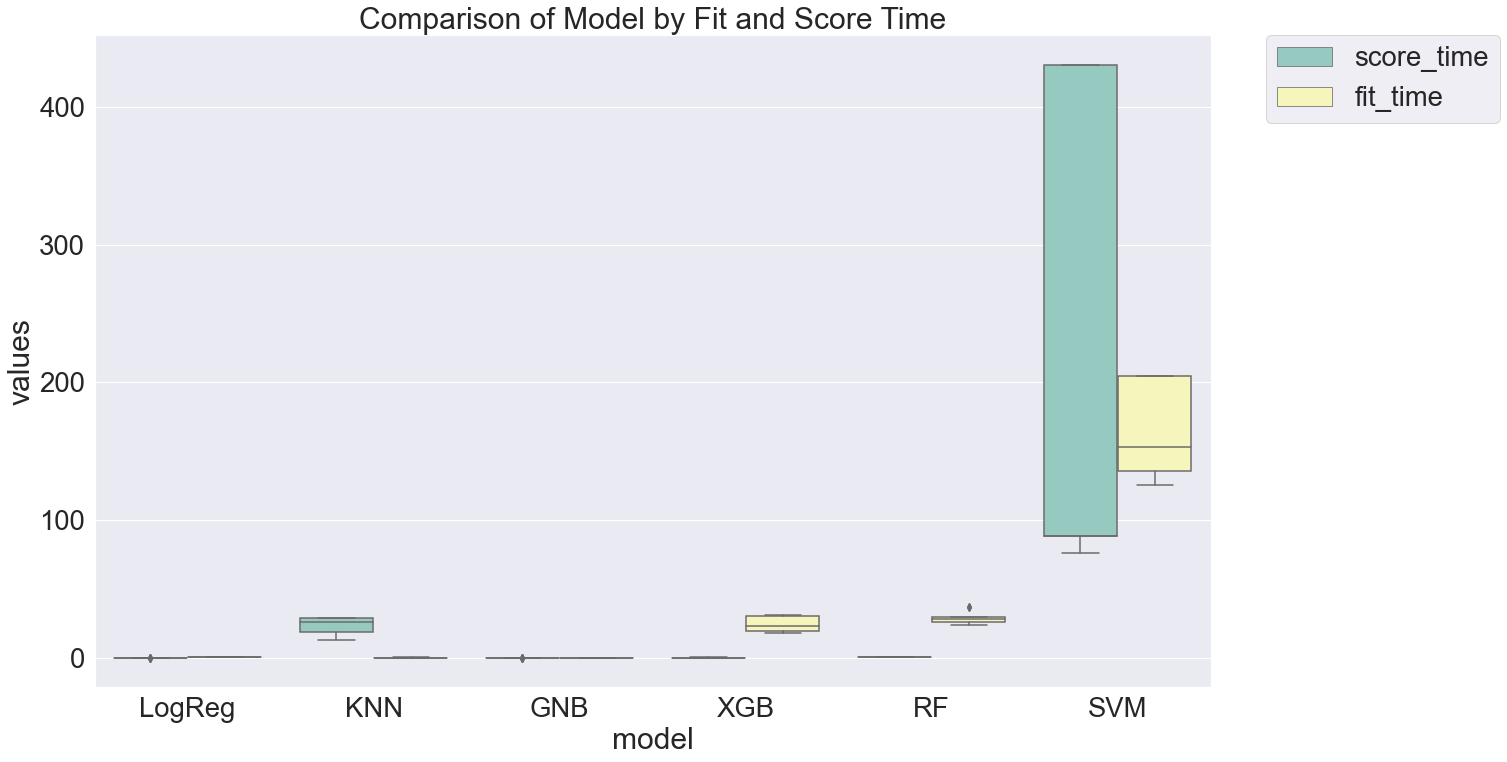

In [26]:
def plot_time_comparison():
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of Model by Fit and Score Time')
plot_time_comparison()

Again, it is evidently clear that SVMs are not good for this data, as will not fit the data properly and is very slow to train / score.

Interestingly, XGBoost, the best performing model is a little quick in training and testing, if not the quickest.

In [27]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test_f1_weighted           test_accuracy            \
                    std      mean           std      mean   
model                                                       
GNB            0.002446  0.366354      0.002654  0.509459   
KNN            0.005316  0.852593      0.005204  0.853552   
LogReg         0.015971  0.577208      0.010775  0.590520   
RF             0.001985  0.978103      0.001985  0.978103   
SVM            0.022930  0.525026      0.014417  0.574872   
XGB            0.000695  0.988242      0.000695  0.988242   

       test_precision_weighted           test_recall_weighted            \
                           std      mean                  std      mean   
model                                                                     
GNB                   0.010157  0.593022             0.002654  0.509459   
KNN                   0.004121  0.862924             0.005204  0.853552   
LogReg                0.008427  0.603255             0.010775  0.590520   
RF                    0.001980  0.978130             0.001985  0.978103   
SVM                   0.013052  0.626421             0.014417  0.574872   
XGB                   0.000689  0.988247             0.000695  0.988242   

       test_roc_auc            
                std      mean  
model                          
GNB        0.001531  0.510181  
KNN        0.003775  0.923786  
LogReg     0.008133  0.628013  
RF         0.000221  0.997479  
SVM        0.014598  0.668215  
XGB        0.000083  0.999283

In [28]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

fit_time              score_time            
              std        mean         std        mean
model                                                
GNB      0.006629    0.074794    0.014834    0.062634
KNN      0.048446    0.069812    6.427220   23.274524
LogReg   0.056552    0.780809    0.006398    0.025785
RF       3.648437   28.087160    0.174037    0.514669
SVM     31.867817  162.986059  166.061018  199.826180
XGB      4.889471   24.510174    0.019868    0.098874

Clearly, XGBoost performed the best and therefore, I select this algorithm for my further study.

## Evaluating XGBoost model with different techniques

Here, I train XGBoost Classifier on the data from the 1st, 2nd & 3rd year and then evaluate the same model on the unseen / untouched data from the 4th and 5th year.

I try different techniques (to handle an imbalanced dataset) on the model and data to evaluate which would be the better performing for this use-case.
1. With and without Oversampling.
2. with and without assigning Class Weights.

In [33]:
def evaluate_model(df_train, df_evaluate, smote, class_penalty):
#     prepare training data
    data = df_train.values
    X = data[:, :-1]
    Y = data[:, -1]
    
    if smote == True:
    #     Oversampling the data using SMOTE
        oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
        X, Y = oversample.fit_resample(X, Y)
    
#     split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
#     train model
    if class_penalty == True:
#         Assigning class weights to model
        counter = Counter(Y)
        estimate = counter[0] / counter[1]
        model_XGB = XGBClassifier(scale_pos_weight=estimate)
    else:
        model_XGB = XGBClassifier()
        
    eval_set = [(X_train, Y_train), (X_test, Y_test)]
    model_XGB.fit(X_train , Y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

#     test model and get a classification report
    y_pred = model_XGB.predict(X_test)
    print("Classification report of 1, 2 & 3 year dataset")
    print(classification_report(Y_test, y_pred))
    print("\n")
    
#     plot confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_confusion_matrix(model_XGB, X_test, Y_test, ax=ax)  
    plt.show()
    
#     plot loss and error graph of the model
    results = model_XGB.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

#     plot log loss
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()

    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    
#     plot classification error
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()

    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()
    
#     Evaluating XG Boost Classifier on unseen data (dataset of 4 & 5 year)

#     Extracting feature and target variables
    data_eval = df_evaluate.values
    X_eval = data_eval[:, :-1]
    Y_eval = data_eval[:, -1]
    
#     print classification report
    y_pred_eval = model_XGB.predict(X_eval)
    print("Classification report of 4 & 5 year dataset")
    print(classification_report(Y_eval, y_pred_eval))   
    
#     plot confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_confusion_matrix(model_XGB, X_eval, Y_eval, ax=ax)  
    plt.show()
    
#     Show Sensitivity-Specificity Metrics
    cm1 = confusion_matrix(Y_eval, y_pred_eval)
    total1=sum(sum(cm1))
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)
    G_mean = math.sqrt(sensitivity1*specificity1)
    print("G-mean: ", G_mean)
    
    return G_mean, model_XGB

def compare_models():
    results = []
    models = []
    print("XGBoost simple\n")
    G_mean1, model_XGB1 = evaluate_model(df123, df45, False, False)
    print("------------------------------------------------------------")
    print("\nXGBoost with smote and class weights\n")
    G_mean2, model_XGB2 = evaluate_model(df123, df45, True, True)
    print("------------------------------------------------------------")
    print("\nXGBoost only with smote\n")
    G_mean3, model_XGB3 = evaluate_model(df123, df45, True, False)
    print("------------------------------------------------------------")
    print("\nXGBoost only with smote\n")
    G_mean4, model_XGB4 = evaluate_model(df123, df45, False, True)
    print("------------------------------------------------------------")
    names = ['XGBoost simple', 'XGBoost with smote and class weights', 'XGBoost only with smote', 'XGBoost only with smote']
    
    results.append(G_mean1)
    results.append(G_mean2)
    results.append(G_mean3)
    results.append(G_mean4)
    
    models.append(model_XGB1)
    models.append(model_XGB2)
    models.append(model_XGB3)
    models.append(model_XGB4)
    
    d = {'Names':names,'Model':models,'G-mean':results}
    df = pd.DataFrame(d)
    
#     Save the best performing model
    max_loc = df['G-mean'].idxmax()
    best_model = df.iloc[max_loc]['Model']
    pickle.dump(best_model, open("BestModel.pickle.dat", "wb"))
    
    return df

XGBoost simple

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      7936
         1.0       0.93      0.57      0.71       375

    accuracy                           0.98      8311
   macro avg       0.96      0.78      0.85      8311
weighted avg       0.98      0.98      0.98      8311





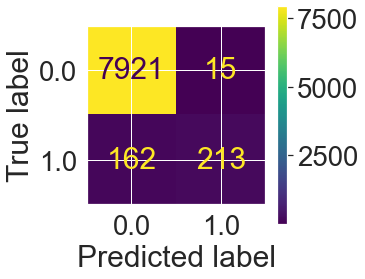

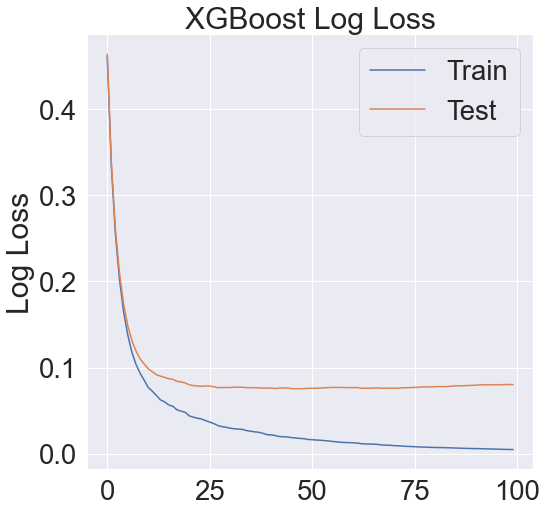

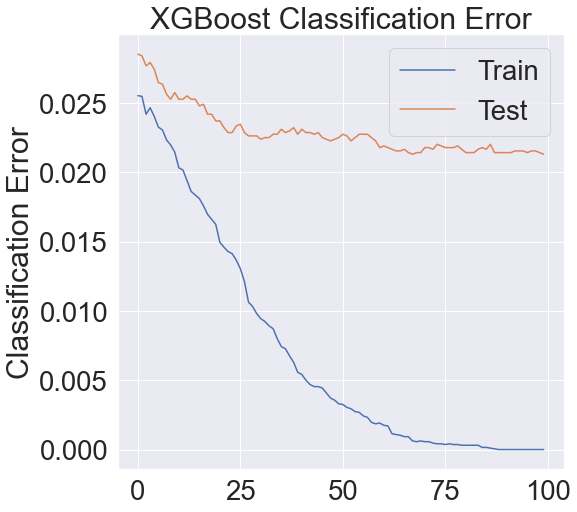

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     14777
         1.0       0.97      0.38      0.55       925

    accuracy                           0.96     15702
   macro avg       0.97      0.69      0.76     15702
weighted avg       0.96      0.96      0.96     15702



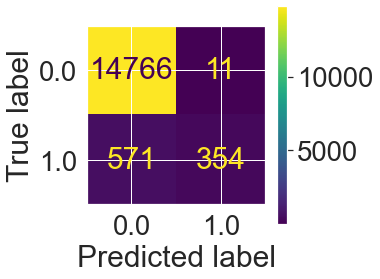

Accuracy :  0.9629346580053496
Sensitivity :  0.9992555999187928
Specificity :  0.3827027027027027
G-mean:  0.6183994006948362
------------------------------------------------------------

XGBoost with smote and class weights

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7957
         1.0       0.99      0.99      0.99      7966

    accuracy                           0.99     15923
   macro avg       0.99      0.99      0.99     15923
weighted avg       0.99      0.99      0.99     15923





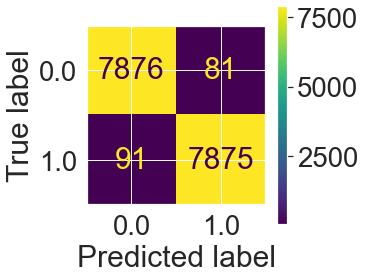

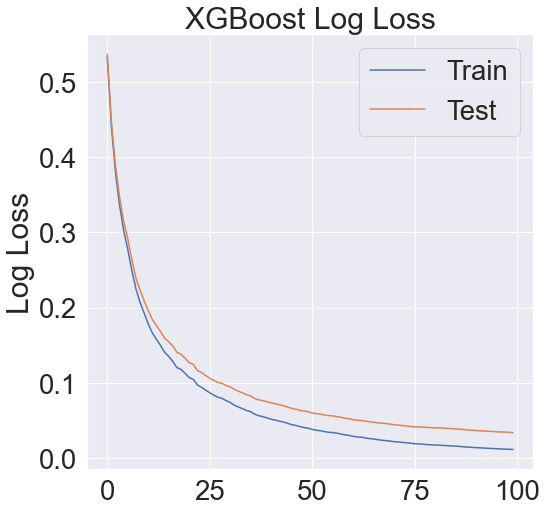

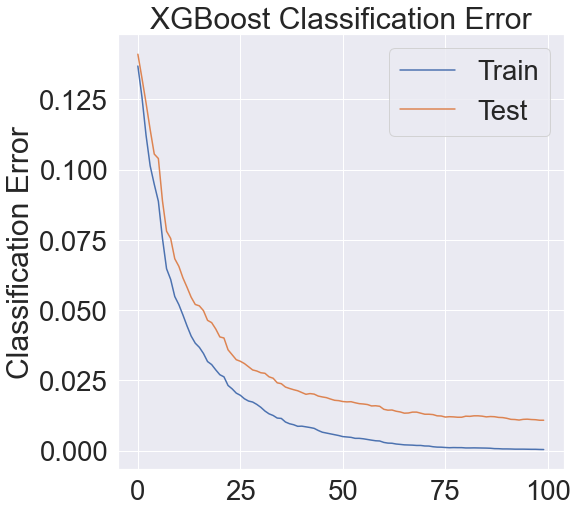

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     14777
         1.0       0.63      0.68      0.65       925

    accuracy                           0.96     15702
   macro avg       0.81      0.83      0.82     15702
weighted avg       0.96      0.96      0.96     15702



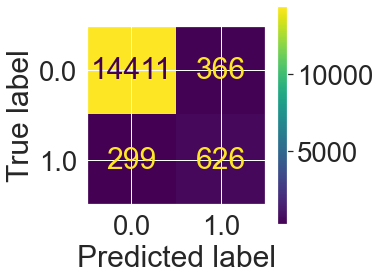

Accuracy :  0.957648707171061
Sensitivity :  0.9752317791161941
Specificity :  0.6767567567567567
G-mean:  0.8124005760219507
------------------------------------------------------------

XGBoost only with smote

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7957
         1.0       0.99      0.99      0.99      7966

    accuracy                           0.99     15923
   macro avg       0.99      0.99      0.99     15923
weighted avg       0.99      0.99      0.99     15923





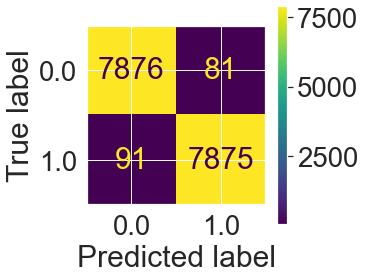

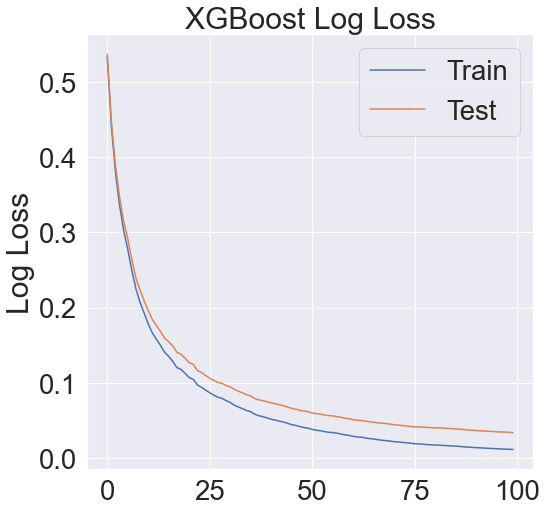

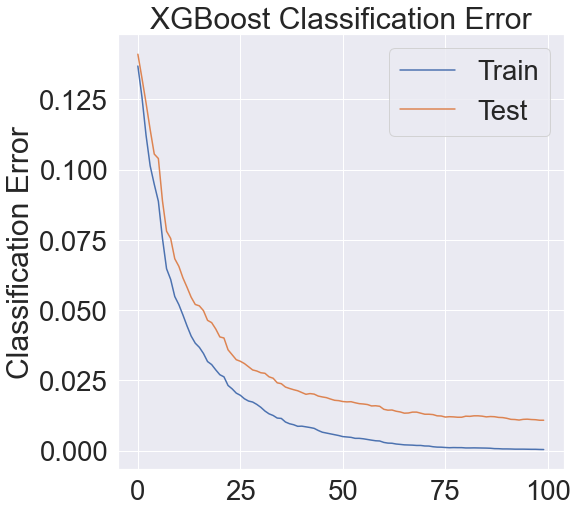

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     14777
         1.0       0.63      0.68      0.65       925

    accuracy                           0.96     15702
   macro avg       0.81      0.83      0.82     15702
weighted avg       0.96      0.96      0.96     15702



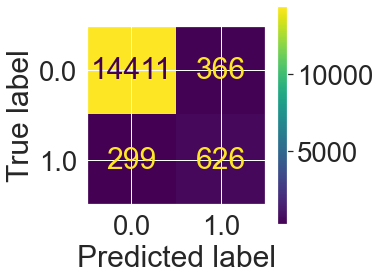

Accuracy :  0.957648707171061
Sensitivity :  0.9752317791161941
Specificity :  0.6767567567567567
G-mean:  0.8124005760219507
------------------------------------------------------------

XGBoost only with smote

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      7936
         1.0       0.88      0.63      0.73       375

    accuracy                           0.98      8311
   macro avg       0.93      0.81      0.86      8311
weighted avg       0.98      0.98      0.98      8311





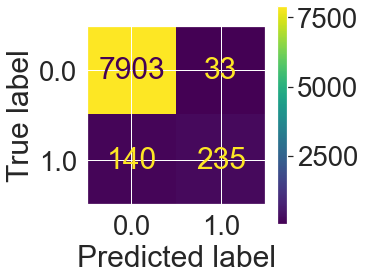

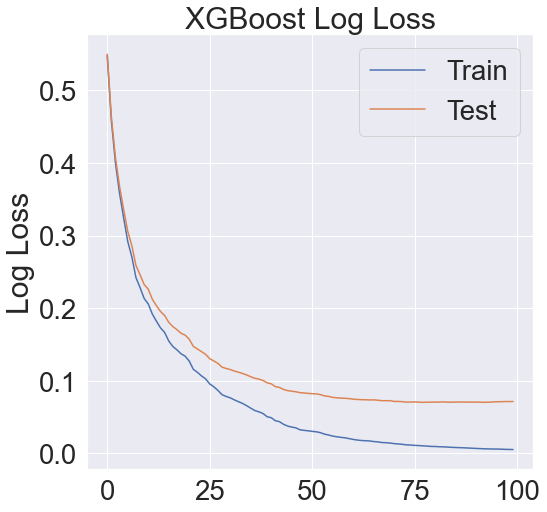

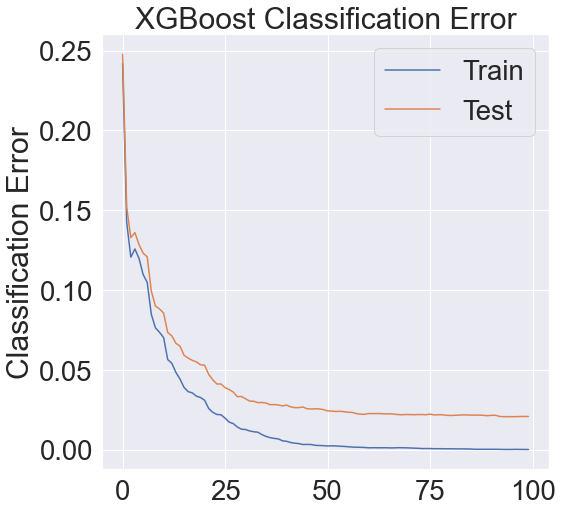

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     14777
         1.0       0.94      0.51      0.67       925

    accuracy                           0.97     15702
   macro avg       0.96      0.76      0.82     15702
weighted avg       0.97      0.97      0.97     15702



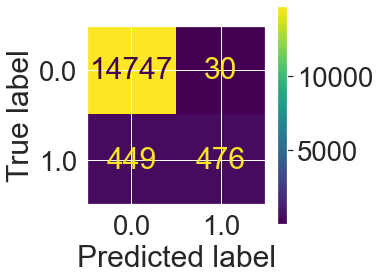

Accuracy :  0.9694943319322379
Sensitivity :  0.9979698179603438
Specificity :  0.5145945945945946
G-mean:  0.7166239417511422
------------------------------------------------------------
Wall time: 1min 22s


In [34]:
%%time
XGB_comparison = compare_models()

In [211]:
XGB_comparison

,Names,Model,G-mean
0,XGBoost simple,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.618399
1,XGBoost with smote and class weights,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.812401
2,XGBoost only with smote,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.812401
3,XGBoost only with smote,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.716624


In [212]:
loadedXGB_model = pickle.load(open("BestModel.pickle.dat", "rb"))

In [213]:
print(loadedXGB_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     14777
         1.0       0.63      0.68      0.65       925

    accuracy                           0.96     15702
   macro avg       0.81      0.83      0.82     15702
weighted avg       0.96      0.96      0.96     15702



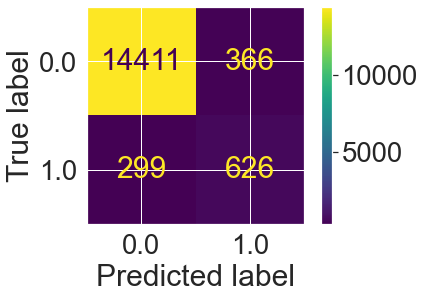

Accuracy :  0.957648707171061
Sensitivity :  0.9752317791161941
Specificity :  0.6767567567567567
G-mean:  0.8124005760219507


Wall time: 460 ms


In [214]:
%%time
# Evaluating XG Boost Classifier on unseen data (dataset of 4 & 5 year)

# Extracting feature and target variables
data45 = df45.values
X45 = data45[:, :-1]
Y45 = data45[:, -1]

y45_pred = loadedXGB_model.predict(X)
print(classification_report(Y45, y45_pred))

plot_confusion_matrix(loadedXGB_model, X45, Y45)  
plt.show()

cm1 = confusion_matrix(Y45, y45_pred)
total1=sum(sum(cm1))
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)
G_mean = math.sqrt(sensitivity1*specificity1)
print("G-mean: ", G_mean)
print("\n")

### Turns out XGBoost with oversampling performs the best

## Hyperparamter Tuning

Now, I try to find the best set of training parameters for XGBoost, to see if there is scope for further model improvement.

I use HYPEROPT for this technique, which is a powerful python library that search through an hyperparameter space of values and find the best possible values that yield the minimum of the loss function.

In [219]:
# Extracting feature and target variables
data_ht = df123.values
X_ht = data_ht[:, :-1]
Y_ht = data_ht[:, -1]

# Oversampling the data using SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
X_ht, Y_ht = oversample.fit_resample(X_ht, Y_ht)

# Splitting data into train and test
X_ht_train, X_ht_test, Y_ht_train, Y_ht_test = train_test_split(X_ht, Y_ht, test_size=0.3, random_state=0)

In [220]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [221]:
def objective(space):
    clf = XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_ht_train, Y_ht_train), (X_ht_test, Y_ht_test)]
    
    clf.fit(X_ht_train, Y_ht_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred_ht = clf.predict(X_ht_test)
    accuracy = accuracy_score(Y_ht_test, pred_ht>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [222]:
%%time
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.8714438234001131                                                                                                     
SCORE:                                                                                                                 
0.8683037116121334                                                                                                     
SCORE:                                                                                                                 
0.8561200778747723                                                                                                     
SCORE:                                                                                                                 
0.8650379953526346                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.8718206368146706                                                                                                     
SCORE:                                                                                                                 
0.8814293788858883                                                                                                     
SCORE:                                                                                                                 
0.8791684983985429                                                                                                     
SCORE:                                                                                                                 
0.8698109652703636                                                                                                     
SCORE:                                  

In [223]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6680383847476336, 'gamma': 2.498273093402186, 'max_depth': 10.0, 'min_child_weight': 5.0, 'reg_alpha': 43.0, 'reg_lambda': 0.893712677734342}


In [224]:
%%time
# Training XG Boost Classifier with best selected hyperparameters by HYPEROPT 
model_XGB = XGBClassifier(colsample_bytree= 0.6680383847476336, gamma= 2.498273093402186, max_depth= 10, min_child_weight= 5, reg_alpha= 43, reg_lambda= 0.893712677734342)
eval_set = [(X_ht_train, Y_train), (X_ht_test, Y_ht_test)]
model_XGB.fit(X_ht_train , Y_ht_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
y_ht_pred = model_XGB.predict(X_ht_test)
print(classification_report(Y_ht_test, y_ht_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      7957
         1.0       0.97      0.97      0.97      7966

    accuracy                           0.97     15923
   macro avg       0.97      0.97      0.97     15923
weighted avg       0.97      0.97      0.97     15923

Wall time: 22 s


In [225]:
%%time
# Evaluating XG Boost Classifier on unseen data (dataset of 4 & 5 year)

# Extracting feature and target variables
data_ht = df45.values
X_ht = data_ht[:, :-1]
Y_ht = data_ht[:, -1]

y_ht_pred = model_XGB.predict(X_ht)
print(classification_report(Y_ht, y_ht_pred))
fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(model_XGB, X_ht, Y_ht, ax=ax)  
plt.show()
cm1 = confusion_matrix(Y_ht, y_ht_pred)
total1=sum(sum(cm1))
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)
G_mean = math.sqrt(sensitivity1*specificity1)
print("G-mean: ", G_mean)
print("\n")

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     14777
         1.0       0.34      0.75      0.47       925

    accuracy                           0.90     15702
   macro avg       0.66      0.83      0.71     15702
weighted avg       0.95      0.90      0.92     15702

Accuracy :  0.8996306203031461
Sensitivity :  0.9088448264194356
Specificity :  0.7524324324324324
G-mean:  0.8269488034010375


Wall time: 136 ms


Hyperparameter tuning did not really improve the model's accuracy, it shows that the default parameters were much better performing.
Therefore, I go ahead with the XGBoost model with default parameters with oversampling on train dataset and with scale_pos_weight=1.

## Feature Selection

Feature Selection is very important in high risk use-cases. As rightly said, "In reality, only a small number of features will be directly accessible, and gathering additional features is costly", we need to find the most prominent features which affect the performance of the model. Feature selection helps in saving time when collecting data, makes the model simpler and generally a model performs faster with lesser features.

With Feature Selection, we also need to be sure of not removing features if it highly affects the model's performance.

Now, there are some different methods of doing Feature Selection - 
1. Wrapper (Recursive Feature Elimination), 
2. Filter (Statistical Methods - ANOVA, Chi-squared, PCA, etc.) or 
3. Intrinsic (Tree based techniques - RF, XGB, etc.)

In [226]:
# Extracting feature and target variables
data_fs = df123.values
X_fs = data_fs[:, :-1]
Y_fs = data_fs[:, -1]

# Oversampling the data using SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
X_fs, Y_fs = oversample.fit_resample(X_fs, Y_fs)

In [227]:
%%time
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model)
fit = rfe.fit(X_fs, Y_fs)
print("Num Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)
# print("Feature Ranking: %s" % fit.ranking_)
features = list(df123.iloc[:, :-1])
fit.support = fit.support_.tolist()
res = "\n".join("Feature: {} -> {}".format(x, y) for x, y in zip(features, fit.support))
print(res)

Num Features: 32
Feature: Attr1 -> True
Feature: Attr2 -> True
Feature: Attr3 -> False
Feature: Attr4 -> True
Feature: Attr5 -> False
Feature: Attr6 -> True
Feature: Attr7 -> True
Feature: Attr8 -> True
Feature: Attr9 -> True
Feature: Attr10 -> True
Feature: Attr11 -> True
Feature: Attr12 -> True
Feature: Attr13 -> True
Feature: Attr14 -> True
Feature: Attr15 -> False
Feature: Attr16 -> True
Feature: Attr17 -> True
Feature: Attr18 -> True
Feature: Attr19 -> False
Feature: Attr20 -> False
Feature: Attr21 -> False
Feature: Attr22 -> True
Feature: Attr23 -> False
Feature: Attr24 -> True
Feature: Attr25 -> True
Feature: Attr26 -> True
Feature: Attr27 -> False
Feature: Attr28 -> False
Feature: Attr29 -> True
Feature: Attr30 -> False
Feature: Attr31 -> True
Feature: Attr32 -> False
Feature: Attr33 -> True
Feature: Attr34 -> True
Feature: Attr35 -> True
Feature: Attr36 -> True
Feature: Attr37 -> False
Feature: Attr38 -> False
Feature: Attr39 -> False
Feature: Attr40 -> True
Feature: Attr41 ->

In [228]:
%%time
from sklearn.decomposition import PCA

pca = PCA()
fit = pca.fit(X_fs)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [6.78652281e-01 1.22970877e-01 7.37143157e-02 4.89749720e-02
 4.03142329e-02 1.40127762e-02 1.25831516e-02 6.23613471e-03
 2.16153331e-03 1.57966574e-04 7.84746634e-05 6.94936916e-05
 3.40342300e-05 2.60686334e-05 5.78968573e-06 2.81930855e-06
 1.40045366e-06 9.85178424e-07 5.95265895e-07 4.94233103e-07
 3.23166266e-07 3.00365997e-07 2.48416470e-07 2.00865451e-07
 1.14329331e-07 1.01348515e-07 8.63368301e-08 6.70028115e-08
 5.96100398e-08 4.62488675e-08 1.27945352e-08 1.10717558e-08
 9.18387009e-09 7.04752569e-09 5.14813394e-09 3.03606767e-09
 2.29878602e-09 1.60944592e-09 1.46694774e-09 1.03009473e-09
 4.93670866e-10 2.23608535e-10 1.38859044e-10 9.61518672e-11
 8.85779618e-11 4.58649564e-11 3.08960109e-11 2.19182882e-11
 1.49647072e-11 1.33051332e-11 1.18353492e-11 9.33808745e-12
 8.01959993e-12 2.98861295e-12 2.18986692e-12 1.85174390e-12
 1.47685763e-12 7.24208700e-13 4.58715788e-13 3.06592437e-13
 1.54040336e-13 2.23336766e-14 2.68435151e-15 8.95793308e-25]
[[-

Both, RFE and PCA are not helpful for this type of problem. 

#### Since we have already seen XGBoost as the best performing model, I choose XGBoost itself for Feature Selection.

A benefit of using ensembles of decision tree based methods is that they can automatically provide estimates of feature importance from a trained predictive model.

In [257]:
def evaluate_model(df_train, df_evaluate):
#     prepare training data
    data = df_train.values
    X = data[:, :-1]
    Y = data[:, -1]
    
#     Oversampling the data using SMOTE
    oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
    X, Y = oversample.fit_resample(X, Y)
    
#     split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
#     train model
    model_XGB = XGBClassifier()   
    eval_set = [(X_train, Y_train), (X_test, Y_test)]
    model_XGB.fit(X_train , Y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

#     test model and get a classification report
    y_pred = model_XGB.predict(X_test)
    print("Classification report of 1, 2 & 3 year dataset")
    print(classification_report(Y_test, y_pred))
    print("\n")
        
#     plot confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_confusion_matrix(model_XGB, X_test, Y_test, ax=ax)  
    plt.show()
    
#     plot loss and error graph of the model
    results = model_XGB.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

#     plot log loss
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()

    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    
#     plot classification error
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()

    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()
    
#     Evaluating XG Boost Classifier on unseen data (dataset of 4 & 5 year) without oversampling

#     Extracting feature and target variables
    data_eval = df_evaluate.values
    X_eval = data_eval[:, :-1]
    Y_eval = data_eval[:, -1]

#     print classification report
    y_pred_eval = model_XGB.predict(X_eval)
    print("Classification report of 4 & 5 year dataset")
    print(classification_report(Y_eval, y_pred_eval))

#     plot confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_confusion_matrix(model_XGB, X_eval, Y_eval, ax=ax)  
    plt.show()
    
#     Show Sensitivity-Specificity Metrics
    cm1 = confusion_matrix(Y_eval, y_pred_eval)
    total1=sum(sum(cm1))
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)
    G_mean = math.sqrt(sensitivity1*specificity1)
    print("G-mean: ", G_mean)
    print("\n")
    
    return model_XGB

No Feature Selection

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7957
         1.0       0.99      0.99      0.99      7966

    accuracy                           0.99     15923
   macro avg       0.99      0.99      0.99     15923
weighted avg       0.99      0.99      0.99     15923





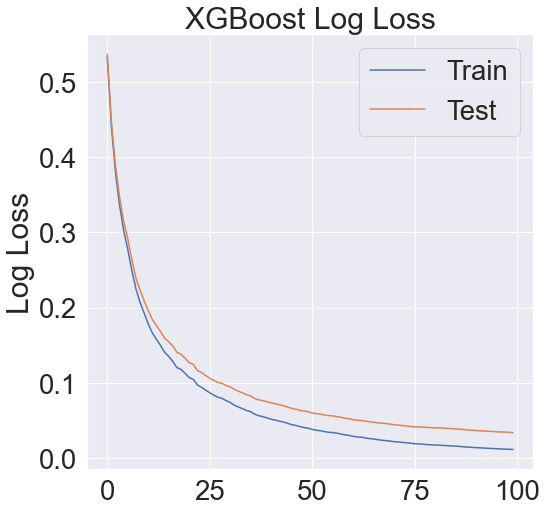

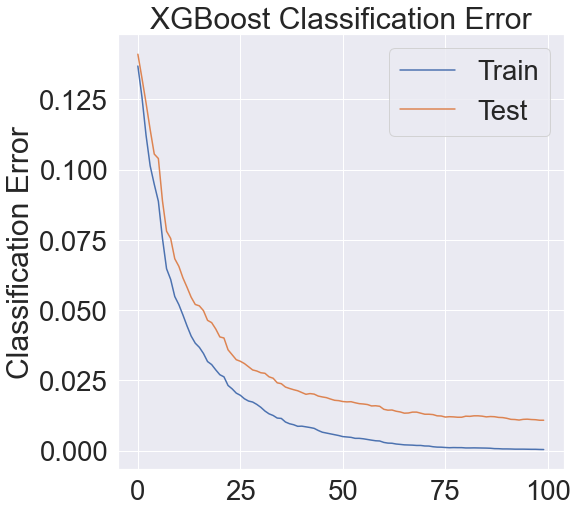

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     14777
         1.0       0.63      0.68      0.65       925

    accuracy                           0.96     15702
   macro avg       0.81      0.83      0.82     15702
weighted avg       0.96      0.96      0.96     15702



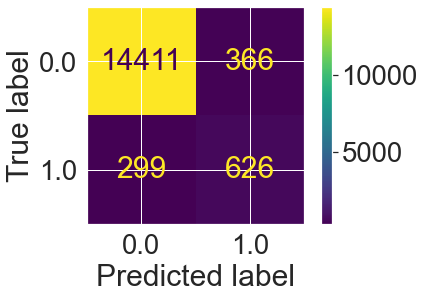

Accuracy :  0.957648707171061
Sensitivity :  0.9752317791161941
Specificity :  0.6767567567567567
G-mean:  0.8124005760219507


Wall time: 20.1 s


In [230]:
%%time
best_model = evaluate_model(df123, df45)

Ranking feature importance by the XG Boost model

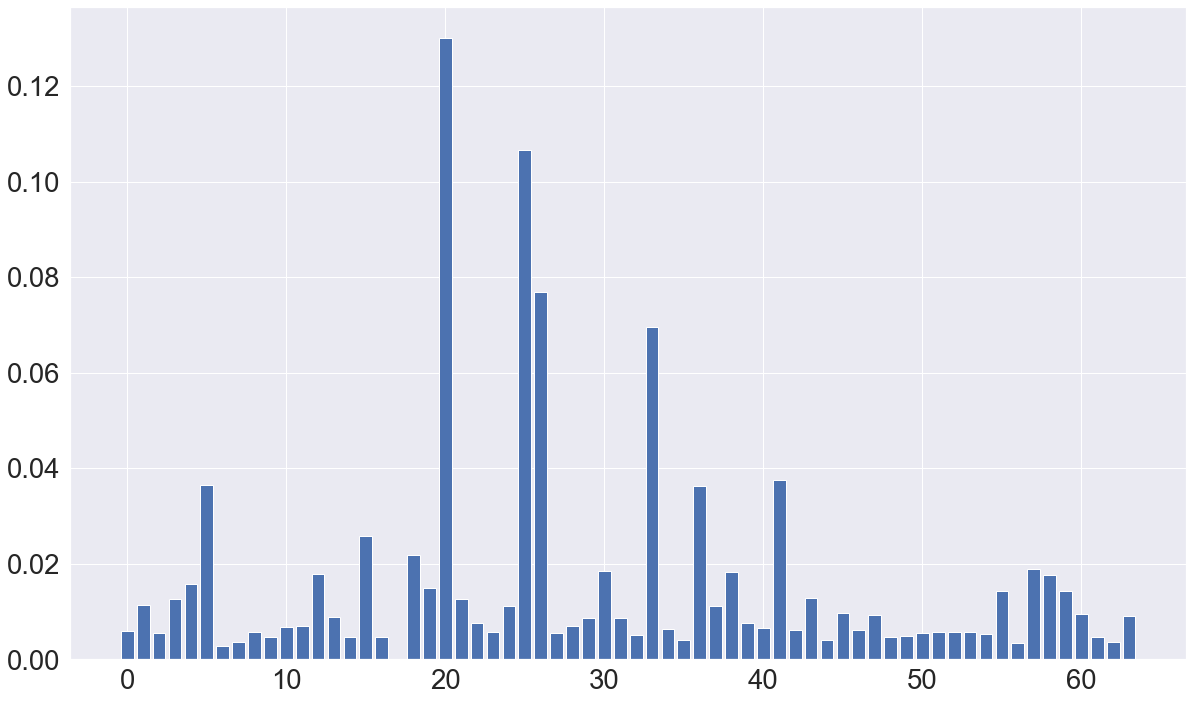

In [231]:
plt.figure(figsize=(20, 12))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.show()

In [237]:
%%time
# Ranking feature importance by the XG Boost model
feature_importance = pd.DataFrame()
feature_importance['features'] = df123.iloc[:, :-1].columns
feature_importance['importances'] = best_model.feature_importances_
feature_importance.sort_values(by='importances',ascending=False,inplace=True)

feature_importance_ranking = feature_importance.reset_index(drop=True)

Wall time: 108 ms


In [238]:
feature_importance_ranking[:34]

,features,importances
0,Attr21,0.130065
1,Attr26,0.106600
2,Attr27,0.076909
3,Attr34,0.069511
4,Attr42,0.037551
5,Attr6,0.036582
6,Attr37,0.036340
7,Attr16,0.025879
8,Attr19,0.021883
9,Attr58,0.018914


In [239]:
feature_importance_ranking.loc[feature_importance_ranking['features'] == 'Attr37']

,features,importances
6,Attr37,0.03634


In [240]:
feature_importance_ranking.loc[feature_importance_ranking['features'] == 'Attr21']

,features,importances
0,Attr21,0.130065


Here, I evaluate different subsets of features using feature_importances function that gives importance to each feature and SelectFromModel class that takes a model and can transform a dataset into a subset with selected features.

To do this, we first train and then evaluate an XGBoost model on the entire training dataset and test datasets respectively.

Using the feature importances calculated from the training dataset, we then wrap the model in a SelectFromModel instance. 
We use this to select features on the training dataset, train a model from the selected subset of features, then evaluate the model on the testset, subject to the same feature selection scheme.

For interest, we test multiple thresholds for selecting features by feature importance.
Specifically, the feature importance of each input variable, essentially allowing us to test each subset of features by importance, starting with all features and ending with a subset with the most important feature.

In [241]:
# Extracting feature and target variables
data_fstest = df123.values
X_fstest = data_fstest[:, :-1]
Y_fstest = data_fstest[:, -1]

# Oversampling the data using SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
X_fstest, Y_fstest = oversample.fit_resample(X_fstest, Y_fstest)

# Splitting data into train and test
X_fstest_train, X_fstest_test, Y_fstest_train, Y_fstest_test = train_test_split(X_fstest, Y_fstest, test_size=0.3, random_state=0)

In [242]:
%%time
# using the already trained and saved model namely, "best_model"
# make predictions for test data and evaluate
y_fstest_pred = best_model.predict(X_fstest_test)
predictions_fstest = [round(value) for value in y_fstest_pred]
accuracy = accuracy_score(Y_fstest_test, predictions_fstest)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(best_model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(best_model, threshold=thresh, prefit=True)
    select_X_fstest_train = selection.transform(X_fstest_train)
    # train model
    selection_model = XGBClassifier(verbosity = 0)
    selection_model.fit(select_X_fstest_train, Y_fstest_train)
    # eval model
    select_X_fstest_test = selection.transform(X_fstest_test)
    y_pred = selection_model.predict(select_X_fstest_test)
    predictions = [round(value) for value in y_fstest_pred]
    accuracy = accuracy_score(Y_fstest_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_fstest_train.shape[1], accuracy*100.0))

Accuracy: 98.92%
Thresh=0.000, n=64, Accuracy: 98.92%
Thresh=0.003, n=63, Accuracy: 98.92%
Thresh=0.003, n=62, Accuracy: 98.92%
Thresh=0.004, n=61, Accuracy: 99.06%
Thresh=0.004, n=60, Accuracy: 99.03%
Thresh=0.004, n=59, Accuracy: 99.03%
Thresh=0.004, n=58, Accuracy: 98.91%
Thresh=0.005, n=57, Accuracy: 98.98%
Thresh=0.005, n=56, Accuracy: 98.96%
Thresh=0.005, n=55, Accuracy: 99.06%
Thresh=0.005, n=54, Accuracy: 99.05%
Thresh=0.005, n=53, Accuracy: 98.91%
Thresh=0.005, n=52, Accuracy: 99.02%
Thresh=0.005, n=51, Accuracy: 98.97%
Thresh=0.005, n=50, Accuracy: 99.06%
Thresh=0.005, n=49, Accuracy: 98.91%
Thresh=0.006, n=48, Accuracy: 98.92%
Thresh=0.006, n=47, Accuracy: 98.93%
Thresh=0.006, n=46, Accuracy: 98.92%
Thresh=0.006, n=45, Accuracy: 99.02%
Thresh=0.006, n=44, Accuracy: 98.88%
Thresh=0.006, n=43, Accuracy: 98.92%
Thresh=0.006, n=42, Accuracy: 99.00%
Thresh=0.006, n=41, Accuracy: 98.95%
Thresh=0.006, n=40, Accuracy: 98.98%
Thresh=0.006, n=39, Accuracy: 98.89%
Thresh=0.006, n=38, A

In [243]:
# Selecting top 34 features
important_features_list = feature_importance_ranking[:34]['features'].tolist()
important_features_list

['Attr21',
 'Attr26',
 'Attr27',
 'Attr34',
 'Attr42',
 'Attr6',
 'Attr37',
 'Attr16',
 'Attr19',
 'Attr58',
 'Attr31',
 'Attr39',
 'Attr13',
 'Attr59',
 'Attr5',
 'Attr20',
 'Attr60',
 'Attr56',
 'Attr44',
 'Attr22',
 'Attr4',
 'Attr2',
 'Attr25',
 'Attr38',
 'Attr46',
 'Attr61',
 'Attr48',
 'Attr64',
 'Attr14',
 'Attr32',
 'Attr30',
 'Attr40',
 'Attr23',
 'Attr29']

Feature Selection - Selecting the half of the best features 

In [60]:
df123_fs = df123[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','Attr30','Attr40','class']].copy()
df45_fs = df45[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','Attr30','Attr40','class']].copy()

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7957
         1.0       0.99      0.99      0.99      7966

    accuracy                           0.99     15923
   macro avg       0.99      0.99      0.99     15923
weighted avg       0.99      0.99      0.99     15923





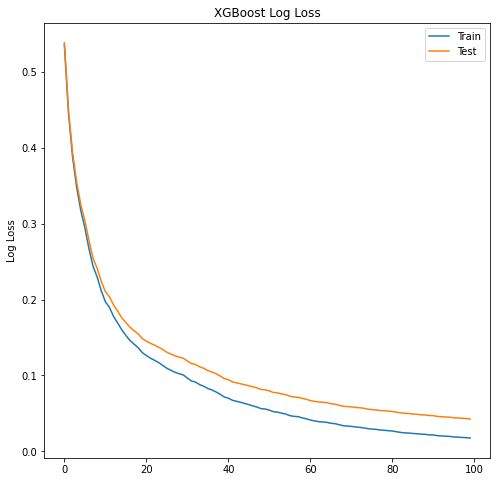

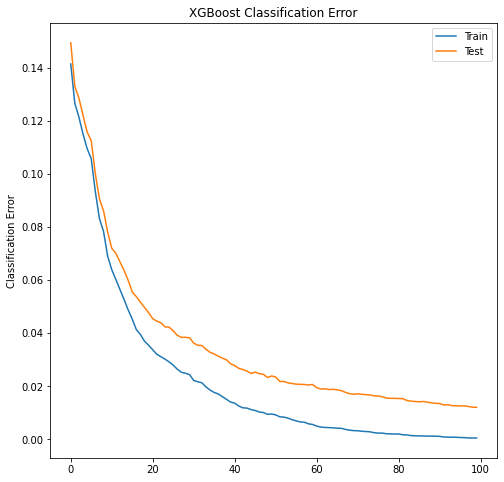

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     14777
         1.0       0.66      0.68      0.67       925

    accuracy                           0.96     15702
   macro avg       0.82      0.83      0.82     15702
weighted avg       0.96      0.96      0.96     15702



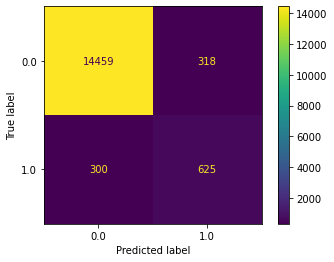

Accuracy :  0.9606419564386702
Sensitivity :  0.978480070379644
Specificity :  0.6756756756756757
G-mean:  0.8131021969524794


Wall time: 9.83 s


In [61]:
%%time
model_fs1 = evaluate_model(df123_fs, df45_fs)

The model accuracy actually increased - G-mean and macro average slightly increased by reducing the features in half

Now, Feature Selection - Selecting the top 30 of the best features 

In [63]:
df123_fs = df123[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','class']].copy()
df45_fs = df45[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','class']].copy()

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7957
         1.0       0.99      0.99      0.99      7966

    accuracy                           0.99     15923
   macro avg       0.99      0.99      0.99     15923
weighted avg       0.99      0.99      0.99     15923





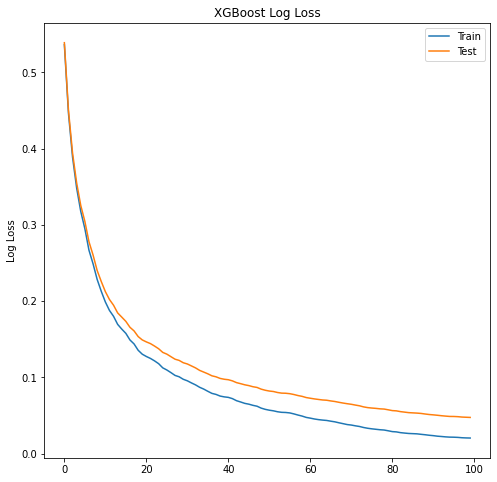

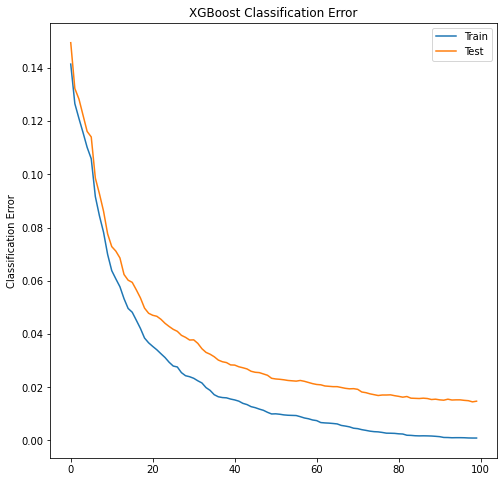

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     14777
         1.0       0.70      0.62      0.66       925

    accuracy                           0.96     15702
   macro avg       0.84      0.80      0.82     15702
weighted avg       0.96      0.96      0.96     15702



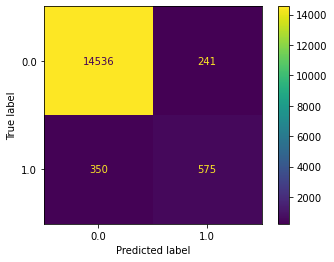

Accuracy :  0.9623614826136798
Sensitivity :  0.983690870948095
Specificity :  0.6216216216216216
G-mean:  0.7819741136208668


Wall time: 9.17 s


In [64]:
%%time
model_fs2 = evaluate_model(df123_fs, df45_fs)

Eveen though the accuracy slightly increased, the recall for 'Bankrupted' class decreased, therefore the G-mean also decreased.

Now, Feature Selection - Selecting the top 24 of the best features 

In [67]:
df123_fs = df123[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','class']].copy()
df45_fs = df45[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','class']].copy()

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7957
         1.0       0.98      0.98      0.98      7966

    accuracy                           0.98     15923
   macro avg       0.98      0.98      0.98     15923
weighted avg       0.98      0.98      0.98     15923





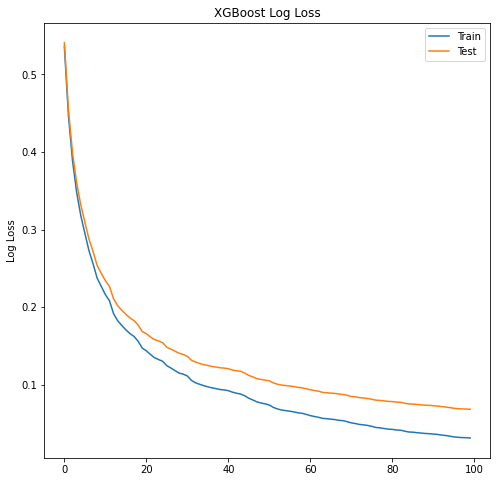

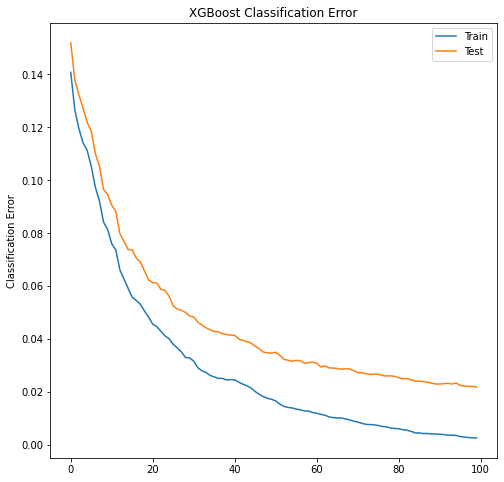

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     14777
         1.0       0.57      0.64      0.60       925

    accuracy                           0.95     15702
   macro avg       0.77      0.81      0.79     15702
weighted avg       0.95      0.95      0.95     15702



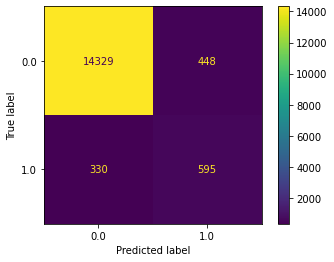

Accuracy :  0.9504521716978729
Sensitivity :  0.969682614874467
Specificity :  0.6432432432432432
G-mean:  0.7897732523379359


Wall time: 7.36 s


In [68]:
%%time
model_fs3 = evaluate_model(df123_fs, df45_fs)

Now, Feature Selection - Selecting only the top 9 of the best features 

In [69]:
df123_fs = df123[['Attr21','Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','class']].copy()
df45_fs = df45[['Attr21','Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','class']].copy()

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.91      7957
         1.0       0.89      0.93      0.91      7966

    accuracy                           0.91     15923
   macro avg       0.91      0.91      0.91     15923
weighted avg       0.91      0.91      0.91     15923





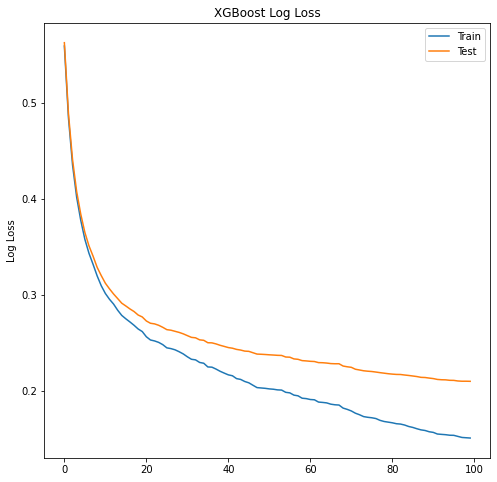

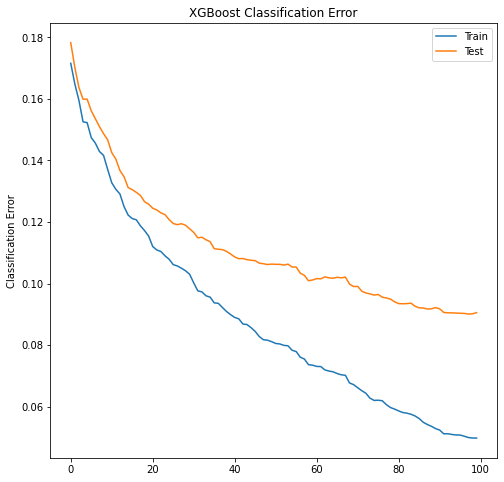

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92     14777
         1.0       0.23      0.55      0.32       925

    accuracy                           0.86     15702
   macro avg       0.60      0.72      0.62     15702
weighted avg       0.93      0.86      0.89     15702



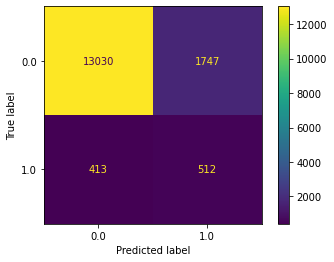

Accuracy :  0.8624379059992358
Sensitivity :  0.8817757325573526
Specificity :  0.5535135135135135
G-mean:  0.6986234922036135


Wall time: 4.37 s


In [70]:
%%time
model_fs4 = evaluate_model(df123_fs, df45_fs)

Feature Selection - half of the top features (without Attr37 - where almost half of the values were missing)

In [108]:
df123_fs = df123[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','Attr30','Attr40','class']].copy()
df45_fs = df45[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','Attr30','Attr40','class']].copy()

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7957
         1.0       0.99      0.99      0.99      7966

    accuracy                           0.99     15923
   macro avg       0.99      0.99      0.99     15923
weighted avg       0.99      0.99      0.99     15923





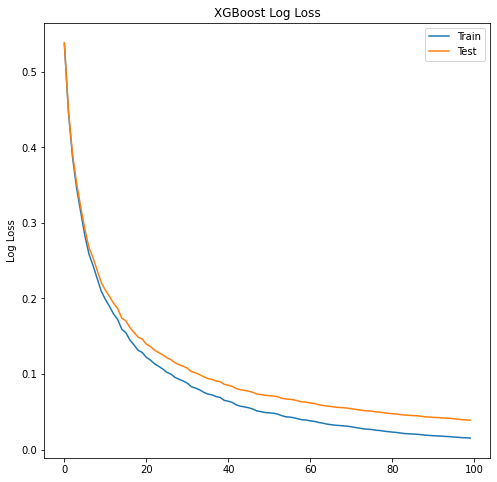

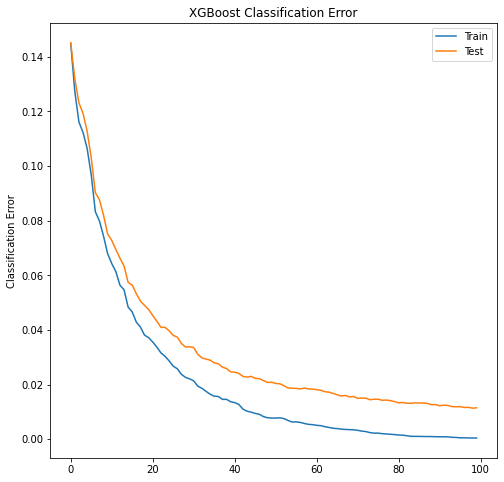

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     14777
         1.0       0.71      0.64      0.68       925

    accuracy                           0.96     15702
   macro avg       0.85      0.81      0.83     15702
weighted avg       0.96      0.96      0.96     15702



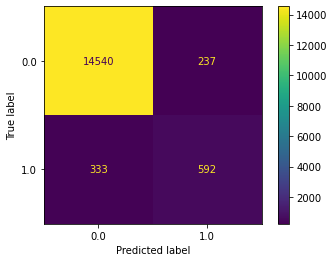

Accuracy :  0.9636988918609094
Sensitivity :  0.9839615618867158
Specificity :  0.64
G-mean:  0.793558693234154


Wall time: 9.03 s


In [109]:
%%time
model_fs5 = evaluate_model(df123_fs, df45_fs)

Feature Selection - half of the top features (without Attr37 and Attr21)

In [139]:
df123_fs = df123[['Attr26','Attr27','Attr34','Attr42','Attr6','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','Attr30','Attr40','class']].copy()
df45_fs = df45[['Attr26','Attr27','Attr34','Attr42','Attr6','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','Attr30','Attr40','class']].copy()

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      7957
         1.0       0.98      0.99      0.99      7966

    accuracy                           0.99     15923
   macro avg       0.99      0.99      0.99     15923
weighted avg       0.99      0.99      0.99     15923





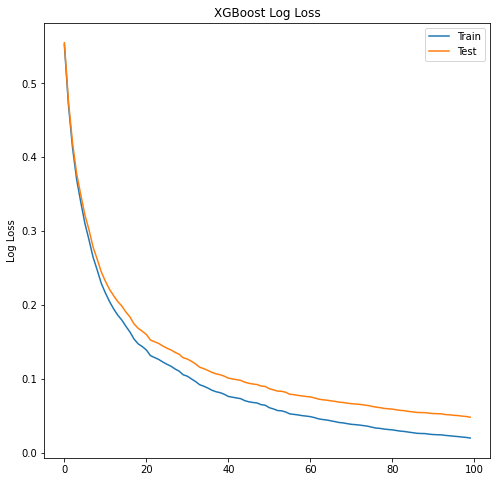

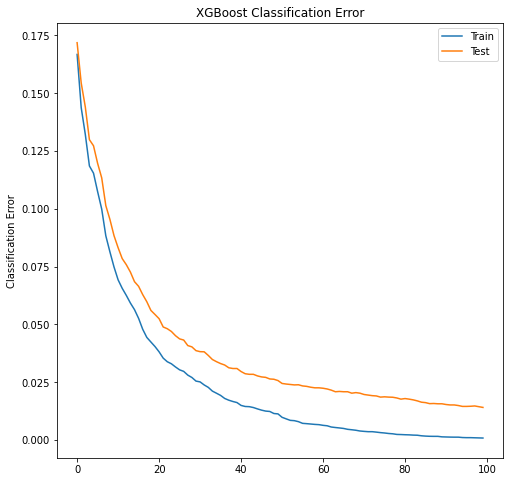

Classification report of 4 & 5 year dataset
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     14777
         1.0       0.68      0.67      0.67       925

    accuracy                           0.96     15702
   macro avg       0.83      0.82      0.83     15702
weighted avg       0.96      0.96      0.96     15702



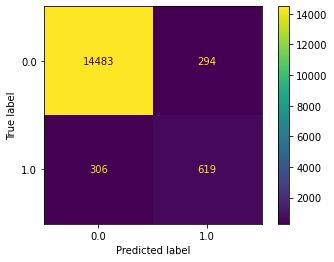

Accuracy :  0.9617883072220099
Sensitivity :  0.980104216011369
Specificity :  0.6691891891891892
G-mean:  0.8098611891142543


Wall time: 12 s


In [140]:
%%time
model_fs6 = evaluate_model(df123_fs, df45_fs)

We can see that reducing the features by half did not affect the model's performance at all, infact there was a very slight increase across all the metrics.

Reducing the features further, only detoriated the performance by the model.

Therefore, with this analysis, we can see that selecting the top 32 features (half of the features) works good for the model and does not necessarily affect the model's performance.

These top 32 Attirbutes / Features (by rank) being - 
1. Attr21 - sales (n) / sales (n-1) , 
2. Attr26 - (net profit + depreciation) / total liabilities , 
3. Attr27 - profit on operating activities / financial expenses , 
4. Attr34 - operating expenses / total liabilities , 
5. Attr42 - profit on operating activities / sales , 
6. Attr6 - retained earnings / total assets , 
7. Attr37 - (current assets - inventories) / long-term liabilities , 
8. Attr16 - (gross profit + depreciation) / total liabilities , 
9. Attr19 - gross profit / sales , 
10. Attr58 - total costs /total sales , 
11. Attr31 - (gross profit + interest) / sales ,
12. Attr39 - profit on sales / sales , 
13. Attr13 - (gross profit + depreciation) / sales ,
14. Attr59 - long-term liabilities / equity , 
15. Attr5 - [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 ,
16. Attr20 - (inventory * 365) / sales ,
17. Attr60 - sales / inventory ,
18. Attr56 - (sales - cost of products sold) / sales ,
19. Attr44 - (receivables * 365) / sales ,
20. Attr22 - profit on operating activities / total assets ,
21. Attr4 - current assets / short-term liabilities ,
22. Attr2 - total liabilities / total assets ,
23. Attr25 - (equity - share capital) / total assets ,
24. Attr38 - constant capital / total assets ,
25. Attr46 - (current assets - inventory) / short-term liabilities ,
26. Attr61 - sales / receivables ,
27. Attr48 - EBITDA (profit on operating activities - depreciation) / total assets ,
28. Attr64 - sales / fixed assets,
29. Attr14 - (gross profit + interest) / total assets ,
30. Attr32 - (current liabilities * 365) / cost of products sold ,
31. Attr30 - (total liabilities - cash) / sales ,
32. Attr40 - (current assets - inventory - receivables) / short-term liabilities 

Here, I develop the same study as before but only with these 32 attributes.
I check the accuracy score starting with all the 32 features and ending with a subset with the most important feature, and simulataneously checking the accuracy score for each subset.

In [249]:
df123_fs = df123[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','Attr30','Attr40','class']].copy()
df45_fs = df45[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','Attr22','Attr4','Attr2','Attr25','Attr38','Attr46','Attr61','Attr48','Attr64','Attr14','Attr32','Attr30','Attr40','class']].copy()

In [250]:
# Extracting feature and target variables
data = df123_fs.values
X = data[:, :-1]
Y = data[:, -1]

# Oversampling the data using SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
X, Y = oversample.fit_resample(X, Y)

# Splitting data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [251]:
%%time
# train model
model_XGB = XGBClassifier()   
eval_set = [(X_train, Y_train), (X_test, Y_test)]
model_XGB.fit(X_train , Y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

# test model and get a classification report and evaluate
y_pred = model_XGB.predict(X_test)
print("Classification report of 1, 2 & 3 year dataset")
print(classification_report(Y_test, y_pred))
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("\n")

# Fit model using each importance as a threshold
thresholds = sort(model_XGB.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_XGB, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(verbosity = 0)
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Classification report of 1, 2 & 3 year dataset
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7957
         1.0       0.99      0.99      0.99      7966

    accuracy                           0.99     15923
   macro avg       0.99      0.99      0.99     15923
weighted avg       0.99      0.99      0.99     15923

Accuracy: 98.79%


Thresh=0.007, n=32, Accuracy: 98.79%
Thresh=0.008, n=31, Accuracy: 98.81%
Thresh=0.009, n=30, Accuracy: 98.73%
Thresh=0.009, n=29, Accuracy: 98.83%
Thresh=0.010, n=28, Accuracy: 98.73%
Thresh=0.010, n=27, Accuracy: 98.78%
Thresh=0.010, n=26, Accuracy: 98.75%
Thresh=0.012, n=25, Accuracy: 98.68%
Thresh=0.013, n=24, Accuracy: 98.71%
Thresh=0.013, n=23, Accuracy: 98.53%
Thresh=0.014, n=22, Accuracy: 98.50%
Thresh=0.014, n=21, Accuracy: 98.37%
Thresh=0.014, n=20, Accuracy: 98.14%
Thresh=0.016, n=19, Accuracy: 98.12%
Thresh=0.017, n=18, Accuracy: 97.52%
Thresh=0.017, n=17, Accuracy: 97.36%
Thresh=0.017, n

We can see that reducing features from 32 and lower also does not majorly affect the model's performance. In fact until the model uses 19 features the average accuracy achieved is 98%.

Testing and testing the XGBoost model on the unseen data with the top 19 features.

In [345]:
df123_fs_19 = df123[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','class']].copy()
df45_fs_19 = df45[['Attr21', 'Attr26','Attr27','Attr34','Attr42','Attr6','Attr37','Attr16','Attr19','Attr58','Attr31','Attr39','Attr13','Attr59','Attr5','Attr20','Attr60','Attr56','Attr44','class']].copy()

In [346]:
# Extracting feature and target variables
data123_19 = df123_fs_19.values
X123_19 = data123_19[:, :-1]
Y123_19 = data123_19[:, -1]

# Oversampling the data using SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
X123_19, Y123_19 = oversample.fit_resample(X123_19, Y123_19)

# Splitting data into train and test
X123_19_train, X123_19_test, Y123_19_train, Y123_19_test = train_test_split(X123_19, Y123_19, test_size=0.3, random_state=0)

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      7957
         1.0       0.90      1.00      0.94      7966

    accuracy                           0.94     15923
   macro avg       0.95      0.94      0.94     15923
weighted avg       0.95      0.94      0.94     15923





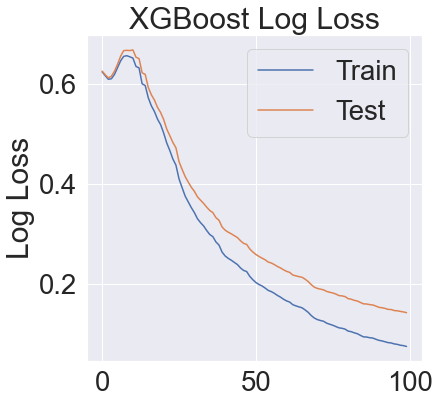

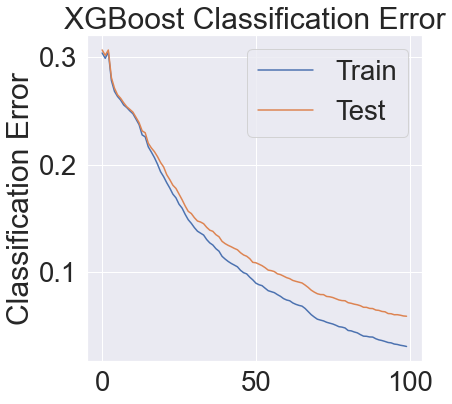

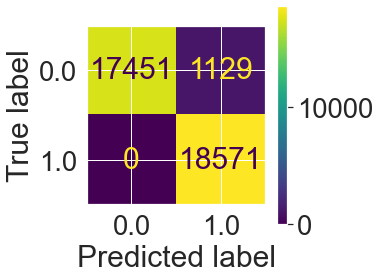

Accuracy :  0.9414055140362997
Sensitivity :  0.8863893427171045
Specificity :  0.9963595279939744
G-mean:  0.9397672409317658


Wall time: 6.31 s


In [347]:
%%time
# Training XG Boost Classifier with 19 features
model_XGB = XGBClassifier(scale_pos_weight=50)
eval_set = [(X123_19_train, Y123_19_train), (X123_19_test, Y123_19_test)]
model_XGB.fit(X123_19_train , Y123_19_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

# Testing
y123_19_pred = model_XGB.predict(X123_19_test)
print(classification_report(Y123_19_test, y123_19_pred))    
print("\n")

# plot loss and error graph of the model
results = model_XGB.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()

plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

cm1123_19 = confusion_matrix(Y123_19_test, y123_19_pred)
# plot confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(model_XGB, X123_19_train, Y123_19_train, ax=ax)  
plt.show()
total1=sum(sum(cm1123_19))
accuracy1=(cm1123_19[0,0]+cm1123_19[1,1])/total1
print ('Accuracy : ', accuracy1)
sensitivity1 = cm1123_19[0,0]/(cm1123_19[0,0]+cm1123_19[0,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = cm1123_19[1,1]/(cm1123_19[1,0]+cm1123_19[1,1])
print('Specificity : ', specificity1)
G_mean = math.sqrt(sensitivity1*specificity1)
print("G-mean: ", G_mean)
print("\n")

In [348]:
data45_19 = df45_fs_19.values
X45_19 = data45_19[:, :-1]
Y45_19 = data45_19[:, -1]
# count examples in each class
counter = Counter(Y45_19)
print(counter)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Counter({0.0: 14777, 1.0: 925})
Estimate: 15.975


              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92     14777
         1.0       0.26      0.78      0.38       925

    accuracy                           0.85     15702
   macro avg       0.62      0.82      0.65     15702
weighted avg       0.94      0.85      0.89     15702



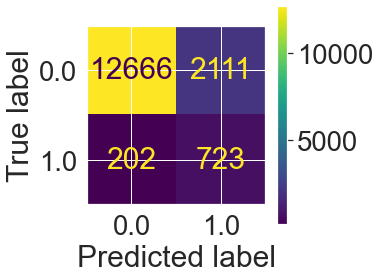

Accuracy :  0.8526939243408483
Sensitivity :  0.8571428571428571
Specificity :  0.7816216216216216
G-mean:  0.8185116920126371


Wall time: 337 ms


In [349]:
%%time
# Evaluating the XG Boost Classifier (with 19 features) on unseen data (dataset of 4 & 5 year)

# Extracting feature and target variables
data45_19 = df45_fs_19.values
X45_19 = data45_19[:, :-1]
Y45_19 = data45_19[:, -1]

y45_19_pred = model_XGB.predict(X45_19)
print(classification_report(Y45_19, y45_19_pred))

cm145_19 = confusion_matrix(Y45_19, y45_19_pred)
# plot confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(model_XGB, X45_19, Y45_19, ax=ax)  
plt.show()
total1=sum(sum(cm145_19))
accuracy1=(cm145_19[0,0]+cm145_19[1,1])/total1
print ('Accuracy : ', accuracy1)
sensitivity1 = cm145_19[0,0]/(cm145_19[0,0]+cm145_19[0,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = cm145_19[1,1]/(cm145_19[1,0]+cm145_19[1,1])
print('Specificity : ', specificity1)
G_mean = math.sqrt(sensitivity1*specificity1)
print("G-mean: ", G_mean)
print("\n")

In fact the model does not see a steep decline in performance even after reducing the input features from 64 to 19.

Given the client's preference and use-case, we can understand where the model's accuracy preference should lie and train the model using those preferences in mind. 

In my opinion, for predicting the chance of bankruptcy, we also need to be sure that we do not falsely classify companies which are likely to go bankrupt with not bankruptcy. So to reduce the chances of False-Negative cases, we can increase the weightage to scale_pos_weight, we can reduce the occurence of predictions where the cases where the company is acutally bankrupt, but the model predicts otherwise. This has a trade-off, where the model likely predicts more cases of bankruptcy, so there are more cases of False-Positive (not bankrupt, but predicted to be bankrupt), which is not often such a bad thing.

The implementation provides a hyperparameter designed to tune the behavior of the algorithm for imbalanced classification problems; this is the scale_pos_weight hyperparameter.
XGBoost is trained to minimize a loss function and the “gradient” in gradient boosting refers to the steepness of this loss function, e.g. the amount of error. Gradients are used as the basis for fitting subsequent trees added to boost or correct errors made by the existing state of the ensemble of decision trees.
The scale_pos_weight value is used to scale the gradient for the positive class. As such, the scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

As the data from the 4th and 5th year is untouched, it has imbalanced distrubtion of class (94% to 6%), we can estimate the weightage of the minority class and apply the estimate the weightage we need to pass as a parameter for scale_pos_weight to train the XGBoost Classifier.
The XGBoost documentation suggests a fast way to estimate this value using the training dataset as the total number of examples in the majority class divided by the total number of examples in the minority class:
- scale_pos_weight = total_negative_examples / total_positive_examples

## Conclusion

The presented model is not limited to Polish companies but represents a general framework that can be applied to an arbitrary given data from the considered domain. 
To fill missing values, I simply filled those values by the mean of the other values of the same attribute.
To tackle the problem of imbalancing, I oversampled the dataset but also tested the fitted model on an unseen and untouched data, which was not manipulated (with the exception of filling missing values with mean), so to get a clear score and understanding of the model's performance without any bias.

Next steps:
1. Consult with the client on how to deal with missing values. As simple approaches (mean imputation) are easy to implement, but can lead to high bias. There are several ways to handle missing values, so to understand from them which one would make the most sense in this domain. Imputation of missing values can be divided between Univariate feature imputation & Multivariate feature imputation, some other exampels being Multivariate Imputation using Chained Equations (MICE), Nearest Neighbors (k-NN) Imputation, etc. 
2. Understand the client's expectations from this predictive model. We can also use the model also to provide probability of bankruptcy, rather than simply classifying. Using the 'predict_proba' function instead of 'predict'.
3. Provide the list of the top 32 important features necessary for a model and consult with the client on which are most easily accessible and not time consuming.
4. With proper validation with domain experts, we can prepare or even gather more core features and incorporate complex features using the already maintained features as baseline.
5. As there was a lot of missing data, the feature selection technique would not be that accurate if the data is so sparse. Therefore, for future study, we need to be sure that the data we collect has no bias and is less sparse.
6. Understand better on the distirbution of data over the span of 5 years and if it makes sense to train the model seperately for each year or to train a model on general features (which affects the chance of bankruptcy) and treating them as historical features.